In [44]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import curve_fit

%matplotlib notebook

import matplotlib.pyplot as plt

## Load and display the MC data

In [106]:
dtyp = [("L", int), ("beta", float), ("g_im", float), ("err_g_im", float),
        ("density", float), ("err_density", float), ("Z", float)]

arr = np.loadtxt("m5.2.dat", dtype=dtyp)
df = pd.DataFrame(arr)

<IPython.core.display.Javascript object>


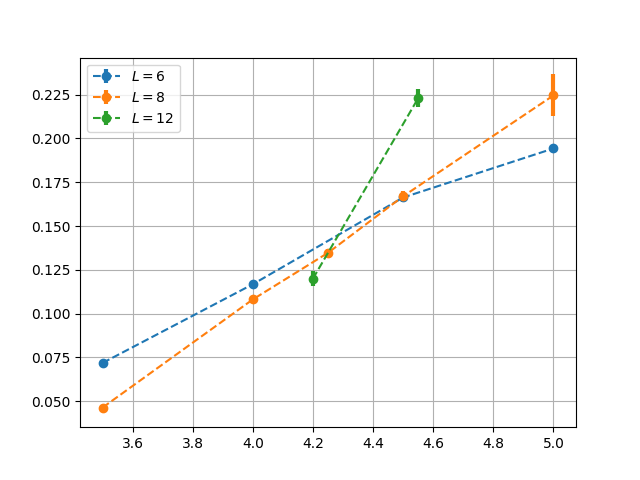

In [3]:
fig, ax = plt.subplots(1, 1)

for L, grp in df.groupby("L"):
    ax.errorbar(grp["beta"], grp["g_im"], yerr=grp["err_g_im"],
                fmt='o--', elinewidth=3, label=r"$L=%s$" % L)

ax.legend(loc='best')
plt.grid(True)
plt.show()

In [148]:
# Zoom into the critical region: visual inspection. In the critical region, $R(T)$ should be approx linear. 
# The size of the critical region shrinks with increasing L.

ranges = {6: [3.4, 5.1],
          8: [3.9, 4.8],
         12: [4.1, 4.6]}

In [167]:
def filter_critical(df, ranges):
    """Remove points too far away from criticality."""
    dfs_all = []

    for L in df["L"].unique():
        df_L = df[df["L"] == L]

        # mask the outside of the critical region
        range_L = ranges[L]
        mask = (df_L["beta"] > range_L[0]) & (df_L["beta"] < range_L[1])
        df_LL = df_L[mask]
        
        dfs_all.append(df_LL)
        
        df_ = pd.concat(dfs_all)
        df_["T"] = 1. / df_["beta"]
        
    return df_

In [168]:
df_all = filter_critical(df, ranges)
df_all

,L,beta,g_im,err_g_im,density,err_density,Z,T
0,6,3.50,0.07180,0.0004,0.17092,0.000254,275.0,0.285714
1,6,4.00,0.11677,0.0008,0.16756,0.000500,129.0,0.250000
2,6,4.50,0.16630,0.0020,0.17051,0.000200,64.0,0.222222
3,6,5.00,0.19430,0.0019,0.17178,0.000400,40.0,0.200000
5,8,4.00,0.10810,0.0020,0.16300,0.001000,26.0,0.250000
6,8,4.25,0.13470,0.0020,0.16000,0.000400,75.2,0.235294
7,8,4.50,0.16700,0.0030,0.16126,0.000500,21.0,0.222222
9,12,4.20,0.12000,0.0044,0.15770,0.000900,48.0,0.238095
10,12,4.55,0.22300,0.0050,0.16000,0.000700,22.2,0.219780


## Fit Tc : G&W arXiv:1008.3348

In [116]:
# Just for convenience

class Bunch(object):
    def __init__(self, **kwds):
        self.__dict__.update(kwds)

In [128]:
w = 0.8
nu = 0.67
nu1 = 1. / nu

def fitfunc(LT, f0, f1, c, Tc):
    """Eq (10) of arXiv:1008.3348."""
    L, T = LT
    res = f0 + f1*(T - Tc)*L**nu1
    res *= 1. + c*L**(-w)
    return res

In [169]:
def fit_Tc(df):
    popt, pcov = curve_fit(fitfunc, (df["L"], df["T"]), df["g_im"],
                       sigma=df["err_g_im"], absolute_sigma=True)
    
    Tc = popt[-1]
    err_Tc = np.sqrt(pcov[-1, -1])
    
    # beta = 1 / T   ==>  err_beta = err_T / T**2
    beta_c = 1. / Tc
    err_beta_c = err_Tc / Tc**2
    
    return Bunch(Tc=Tc, err_Tc=err_Tc,
                 beta_c=beta_c, err_beta_c=err_beta_c,
                 popt=popt, pcov=pcov)

In [170]:
res = fit_Tc(df_all)
print("T_c = ", res.Tc, " +/- ", res.err_Tc)

T_c =  0.23173175813  +/-  0.0039279097781


## Plot $R(L, T)$ and $T_c$

In [35]:
colors = {6: "C0", 8: "C1", 12: "C2"}

In [171]:
def plot_RLT(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    for L in df["L"].unique():
        df_LL = df[df["L"] == L]

        # MC data
        ax.errorbar(df_LL["beta"], df_LL["g_im"], yerr=df_LL["err_g_im"],
                     fmt='o', elinewidth=4, label=r"$L=%s$" % L, color=colors[L])
        
        # linear fits in the critical region
        slope, intercept, _, _, _ = stats.linregress(df_LL["beta"], df_LL["g_im"])
        
        xx = np.array(ranges[L])
        ax.plot(xx, slope*xx + intercept, "-", color=colors[L])

    ax.legend(loc='upper left')
    ax.grid(True)
    return ax

<IPython.core.display.Javascript object>


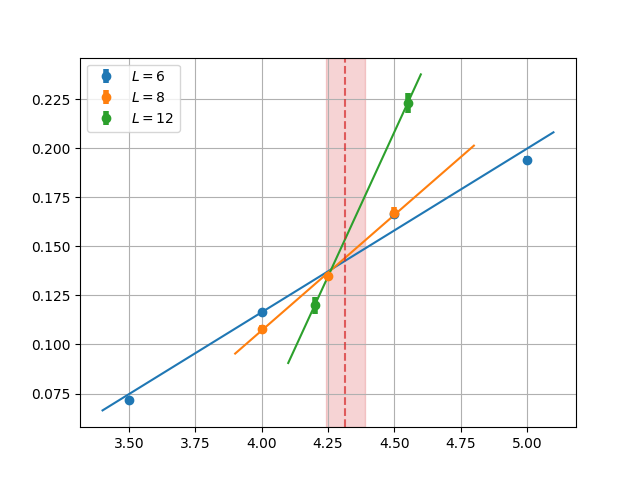

beta_c =  4.31533428163  +/-  0.0731459678095


In [172]:
ax = plot_RLT(df_all)

plt.axvline(res.beta_c, color='C3', alpha=0.7, ls='--')
ax.axvspan(res.beta_c - res.err_beta_c, 
           res.beta_c + res.err_beta_c, alpha=0.2, color="C3")

print("beta_c = ", res.beta_c, " +/- ", res.err_beta_c)

# Redo without limiting the range

<IPython.core.display.Javascript object>


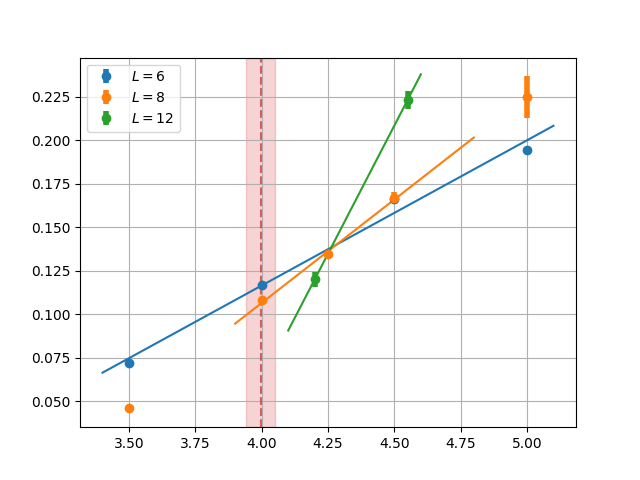

beta_c =  3.99582659308  +/-  0.0545152560706


In [173]:
ranges_1 = {6: [3.4, 5.1],
         8: [3.4, 5.1],
         12: [3.4, 5.1]}

df_all_1 = filter_critical(df, ranges_1)
res_1 = fit_Tc(df_all_1)

ax_1 = plot_RLT(df_all_1)

ax_1.axvline(res_1.beta_c, color='C3', alpha=0.7, ls='--')
ax_1.axvspan(res_1.beta_c - res_1.err_beta_c, 
             res_1.beta_c + res_1.err_beta_c, alpha=0.2, color="C3")

print("beta_c = ", res_1.beta_c, " +/- ",res_1.err_beta_c)

Conclusion: not limiting the range produces utter nonsense. 

## Limit the range of $L=8$, tweak the range of $L=6$

This is to check that small tweaks to the $L=6$ range do not significantly alter the result 

<IPython.core.display.Javascript object>


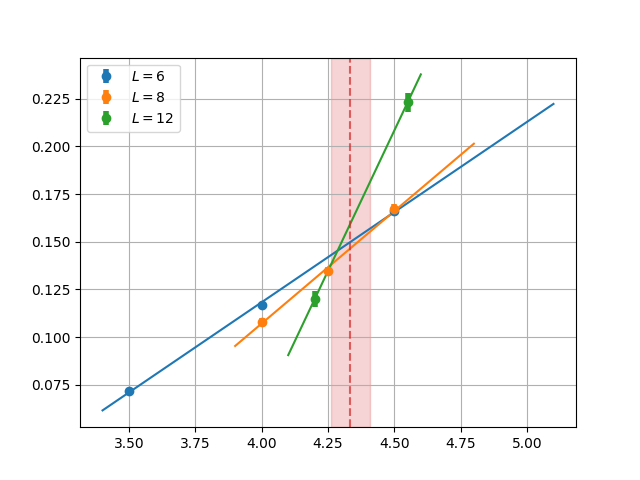

beta_c =  4.33473662041  +/-  0.0723077222633


In [174]:
ranges_2 = {6: [3.4, 4.7],
            8: [3.9, 4.8],
           12: [4.1, 4.6]}

df_all_2 = filter_critical(df, ranges_2)
res_2 = fit_Tc(df_all_2)

ax_2 = plot_RLT(df_all_2)

ax_2.axvline(res_2.beta_c, color='C3', alpha=0.7, ls='--')
ax_2.axvspan(res_2.beta_c - res_2.err_beta_c, 
             res_2.beta_c + res_2.err_beta_c, alpha=0.2, color="C3")

print("beta_c = ", res_2.beta_c, " +/- ",res_2.err_beta_c)

Conclusion: as long as the range is limited, results are consistent.

# Fit Tc for the historic data

In [175]:
path='../arch/data_m5.2/'

frames = []
for L in [6, 8, 12]:
    data = np.loadtxt(path + 'im_%s.dat' % L)
    frame = pd.DataFrame(data[:, :3], columns=["beta", "g_im", "err_g_im"])
    frame["L"] = L
    frames.append(frame)
    
df_h = pd.concat(frames)

df_h

,beta,g_im,err_g_im,L
0,3.50,0.07613,0.0009,6
1,4.00,0.11783,0.0027,6
2,4.50,0.16575,0.0030,6
3,5.00,0.19966,0.0070,6
4,5.50,0.21091,0.0050,6
5,6.00,0.22787,0.0080,6
0,3.60,0.05567,0.0030,8
1,4.00,0.10568,0.0070,8
2,4.25,0.14567,0.0060,8
3,4.50,0.18097,0.0060,8


<IPython.core.display.Javascript object>


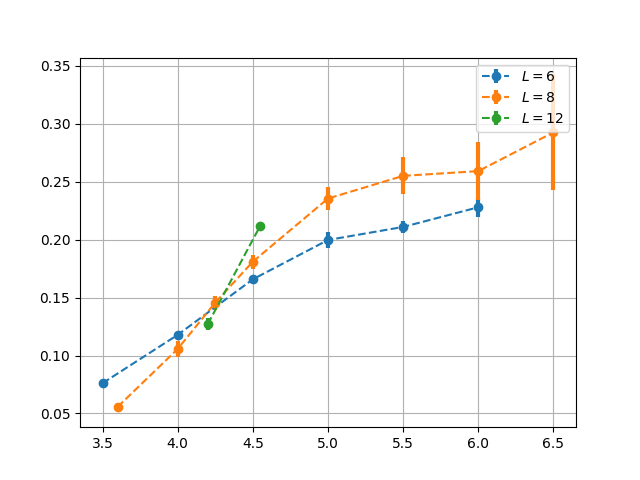

In [165]:
fig, ax = plt.subplots(1, 1)

for L, grp in df_h.groupby("L"):
    ax.errorbar(grp["beta"], grp["g_im"], yerr=grp["err_g_im"],
                fmt='o--', elinewidth=3, label=r"$L=%s$" % L)

ax.legend(loc='best')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


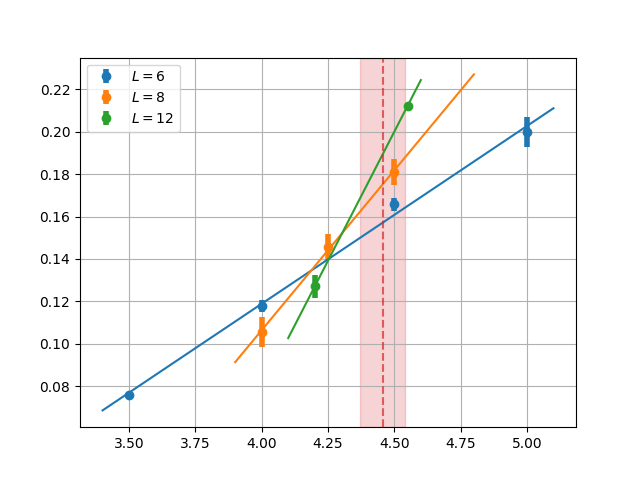

beta_c =  4.45552851317  +/-  0.0843643110814


In [176]:
ranges_h = {6: [3.4, 5.1],
            8: [3.9, 4.8],
           12: [4.1, 4.6]}

df_all_h = filter_critical(df_h, ranges_h)
res_h = fit_Tc(df_all_h)

ax_h = plot_RLT(df_all_h)

ax_h.axvline(res_h.beta_c, color='C3', alpha=0.7, ls='--')
ax_h.axvspan(res_h.beta_c - res_h.err_beta_c, 
             res_h.beta_c + res_h.err_beta_c, alpha=0.2, color="C3")

print("beta_c = ", res_h.beta_c, " +/- ",res_h.err_beta_c)